# UBS-seq Pipeline
## Basic Workflow

**C. Bryan Daniels**

**2/1/2024**

## Project: UBS-seq Basic Pipeline

The purpose of this project is run a minimally viable UBS-seq pipline. For simplicity, it will run several single-end samples, mapping only to the genome. The core steps of the pipeline are:
- cut_apapter
- quality_control
- align2ref
- sort2ref
- dedupe
- filter->all_multi_unique
- call_peaks
- select_groups
- analysis_and_annotation

This pipeline is based upon the paper by [Qing Dai, etal](https://doi.org/10.1038/s41587-023-02034-w) and the UBS-seq pipeline developed by [Chang Ye](https://github.com/y9c/m5C-UBSseq)



## Setup

#### The logic for the Pipeline is defined through a series of Steps using dirs to save intermediate results
1. For each **Step** in the pipeline a dir will be created and labeled **Step** and will contain all files created by that **Step**
2. Within a **Step**, **in_path** and **out_path** will generically refer to the prior and current **Step**
3. Within each **Step**, the appropriate processes will occur. Generally this involves processing files from **in_path** and saving to **out_path**
4. **Abbreviated filenames** should not change through the pipeline (suffixes will reflect current file formats). The dir name should reflect the **Step**, not the filename.
6. The function **mkpath(step)** returns a path for a dir **Step**. It will create a dir if need be, but not overwrite an existing dir
8. The function **fname(path,sample,suffix)** returns a file name without actually creating the file

#### Execution from Command Line

- cd workplace/
- juptyer nbconvert ubs_basic.ipynb --to script
- ipython ubs_basic.py

#### Environment

In [84]:
start = ! echo 'ubs_basic.ipnby | ubs_basic.py STARTED:' `date`; 
start = start[0]; start

'ubs_basic.ipnby | ubs_basic.py STARTED: Sat Feb 3 05:58:39 AM CST 2024'

In [2]:
import os, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
from IPython.display import display, HTML
from snakemake import load_configfile

In [3]:
def fname(path, base, sufix):
    'Return a path and suffix complete filename'
    return Path(path)/f"{base}.{sufix}"

def mkpath(path):
    'Return dir path name; creates (not over-writting) a new dir within the pwd'
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)
    return path

#### Path References

`Waring:` This notebook should be located and executed from within the directory `home_path/workspace/`

`Note:` Github ignores the data/, workspace/ and reference directories, except for `.py` and `.ipynb` files

In [4]:
home_path      = Path.cwd()/'..'
data_path      = home_path/'data'
workspace_path = home_path/'workspace'

Use `config.yaml` to configure `references/`, but not samples in `data/`

In [5]:
config = load_configfile("../config.yaml")

In [6]:
genome_fa  = home_path/config['reference']['genome']['fa'].removeprefix('~/')
genome_idx = home_path/config['reference']['genome']['hisat3n'].removeprefix('~/')

In [7]:
#genome_fa = ref_path/'genome/Homo_sapiens.GRCh38.genome.fa'
#genome_idx = ref_path/'index/hist3n/Homo_sapiens.GRCh38.genome'

In [8]:
# Add to shell PATH
os.environ['PATH'] = f"{str(home_path)}:" + os.environ['PATH'] # home_path
os.environ['PATH'] = '/home/cdaniels/bin/homer:' + os.environ['PATH'] # homer
os.environ['PATH'] = '/home/cdaniels/bin/hisat-3n:' + os.environ['PATH'] # hisat-3n


In [9]:
# Set Java Flag
os.environ['_JAVA_OPTIONS'] = '-Xmx8g'

In [10]:
# Number of cores                                                                                                                                                                                               
nc = get_ipython().getoutput('nproc')                                                                                                                                                                           
nc = int(nc[0])                                                                                                                                                                                                 
nc  

32

#### Functions

In [11]:
def nlines(file):
    'Returns fast linecout (fast)'
    result = subprocess.run(['wc', '-l', file], stdout=subprocess.PIPE)
    n = int(result.stdout.split()[0])
    return n

In [12]:
def nseqs(bam_fastq):
    'Returns number of sequences in bam, sam, fasta or fastq file'
    n = !samtools view -c {bam_fastq}
    return int(n[0])

In [13]:
def samples_string(samples,path,suffix='bam'):
    'Returns a space delimited string of sample files'
    return " ".join([str(fname(path,sample,suffix)) for sample in samples])    

In [14]:
def make_table(ds1, ds2, ds1_name, ds2_name, y_label=None, xs_labels=None, table_label=None):
    'Makes a bar graph comparing two datasets and their corresponding names'
    assert(len(ds1)==len(ds2))
    n = np.arange(len(ds1))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(n - width/2, ds1, width, label=ds1_name)
    rects2 = ax.bar(n + width/2, ds2, width,label=ds2_name)
    ax.set_ylabel(y_label)
    ax.set_title(table_label)
    ax.set_xticks(n)
    ax.set_xticklabels(range(1,len(ds1)+1)) if xs_labels == None else ax.set_xticklabels(xs_labels)
    ax.legend()
    plt.show()

In [15]:
def make_histogram(ds, ds_name, table_label=None, y_label="Frequency", density=True):
    'Makes a histogram for a dataset and its name'
    fig, ax = plt.subplots()
    ax.hist(ds, density=density)
    ax.set_ylabel(y_label)
    ax.set_xlabel(ds_name)
    if table_label is not None:
        ax.set_title(table_label)
    plt.show()

## Step: select_samples

#### Select Samples and Filenames

In [16]:
out_path = mkpath('samples')

#### Project definitions for treated samples, control samples

In [17]:
# short sample names
treated = ["t1","t2","t3"] # Edit
control = [] # Edit
samples = treated + control

In [18]:
samples

['t1', 't2', 't3']

In [19]:
# sample filenames
samples_fn = [data_path/'test0_R1.fq.gz', data_path/'test1_R1.fq.gz', data_path/'test2_R1.fq.gz']

In [20]:
# dict
s2fn = {name: fname for (name,fname) in zip(samples,samples_fn)};
s2fn

{'t1': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test0_R1.fq.gz'),
 't2': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test1_R1.fq.gz'),
 't3': PosixPath('/home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/../data/test2_R1.fq.gz')}

In [21]:
for (s,fn) in s2fn.items():
    ! ln -s {data_path/fn} {fname(out_path,s,"fq.gz")}

ln: failed to create symbolic link 'samples/t1.fq.gz': File exists
ln: failed to create symbolic link 'samples/t2.fq.gz': File exists
ln: failed to create symbolic link 'samples/t3.fq.gz': File exists


Check that the files look correct

In [22]:
!ls -lLh {out_path}

total 647M
-rw-rw-r-- 1 cdaniels cdaniels 178M Feb  1 11:41 t1.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 239M Feb  1 11:41 t2.fq.gz
-rw-rw-r-- 1 cdaniels cdaniels 230M Feb  1 11:41 t3.fq.gz


How many sequence reads do we have per Sample

In [23]:
# Total Reads per Samples
files = [fname(out_path,sample, "fq.gz") for sample in samples]
for f in files:
    ns = nseqs(f)
    print(f"{f}: {ns:,}")

samples/t1.fq.gz: 4,678,947
samples/t2.fq.gz: 6,830,155
samples/t3.fq.gz: 5,919,881


## Step: fastqc_pre

#### Pre Trimming Quality Control

In [24]:
in_path = mkpath("samples")
out_path = mkpath("fastqc_pre")

#### fastqc

In [25]:
! fastqc --help


            FastQC - A high throughput sequence QC analysis tool

SYNOPSIS

	fastqc seqfile1 seqfile2 .. seqfileN

    fastqc [-o output dir] [--(no)extract] [-f fastq|bam|sam] 
           [-c contaminant file] seqfile1 .. seqfileN

DESCRIPTION

    FastQC reads a set of sequence files and produces from each one a quality
    control report consisting of a number of different modules, each one of 
    which will help to identify a different potential type of problem in your
    data.
    
    If no files to process are specified on the command line then the program
    will start as an interactive graphical application.  If files are provided
    on the command line then the program will run with no user interaction
    required.  In this mode it is suitable for inclusion into a standardised
    analysis pipeline.
    
    The options for the program as as follows:
    
    -h --help       Print this help file and exit
    
    -v --version    Print the version of the program and exit

##### paramaters:
- -o output dir

In [26]:
for sample in samples:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1.fq.gz
application/gzip
Analysis complete for t2.fq.gz
application/gzip
Analysis complete for t3.fq.gz


In [27]:
! ls {out_path}

t1_fastqc.html	t2_fastqc.html	t3_fastqc.html
t1_fastqc.zip	t2_fastqc.zip	t3_fastqc.zip


## Step: trimmed

#### Trim the adapter and downstream sequence as well as trimmng lower quality downstream sequence

In [28]:
in_path = mkpath("samples")
out_path = mkpath("trim")

In [29]:
adapter =  "AGATCGGAAGAGCACACGTCT"
barcode3 = "ATCACG"
#adapter = "AGATCGGAAGAGCACACGTCTGAACTCCAG"
#barcode3 = "TATCACGATCACG"

In [30]:
!ls {in_path}

t1.fq.gz  t2.fq.gz  t3.fq.gz


#### cutadapt

In [31]:
! cutadapt --help

cutadapt version 4.6

Copyright (C) 2010 Marcel Martin <marcel.martin@scilifelab.se> and contributors

Cutadapt removes adapter sequences from high-throughput sequencing reads.

Usage:
    cutadapt -a ADAPTER [options] [-o output.fastq] input.fastq

For paired-end reads:
    cutadapt -a ADAPT1 -A ADAPT2 [options] -o out1.fastq -p out2.fastq in1.fastq in2.fastq

Replace "ADAPTER" with the actual sequence of your 3' adapter. IUPAC wildcard
characters are supported. All reads from input.fastq will be written to
output.fastq with the adapter sequence removed. Adapter matching is
error-tolerant. Multiple adapter sequences can be given (use further -a
options), but only the best-matching adapter will be removed.

Input may also be in FASTA format. Compressed input and output is supported and
auto-detected from the file name (.gz, .xz, .bz2). Use the file name '-' for
standard input/output. Without the -o option, output is sent to standard output.

Citation:

Marcel Martin. Cutadapt removes a

```
cutadapt -j {threads} 
            -n 2 
            -a "{params.barcode3}{params.adapter3};e=0.15;o=6;anywhere;" 
            --untrimmed-output={output.fastq_untrimmed} 
            -o - {input} 2>{output.report1} | 
cutadapt -j {threads} 
            -u 5 -u -5 
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}' 
            --max-n=0 
            -q 15 
            --nextseq-trim=15 
            -m 20 
            --too-short-output={output.fastq_tooshort} 
            -o {output.fastq_cut} - >{output.report2}
```

https://cutadapt.readthedocs.io/en/stable/guide.html

##### paramaters:
- -j 0, Number of CPU. Use 0 to autodetect
- --nextseq-trim=15, is used to trim these low-quality tails of 'G's by introducing a variable quality threshold
- --action=trim, trim adapter and downstream sequence
- -a '{barcode3}{adapter};e=0.15;o=6;anywhere;', 
- -n 2, Remove up to COUNT adapters from each read. Default: 1
- -u 5 -u -5, Remove LEN bases from each read. If positve, from beginning. If negative, from end
- --max-n=0, Discard reads with more than COUNT 'N' bases (here any)
- -q 15, Trim low-quality bases from 5' end of eachread before adapter removal.
- -m 20, Discard reads shorter than LEN
- --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}', rename comment of fastq record
- --too-short-output={fname(out_path,sample,"fastq_tooshort")},
- -o {fname(out_path,sample,"fq.gz")}, output file
{fname(in_path,sample,"fq.gz")}, input file

**NOTE:** Added `--length 30` to cutoff reads where C begin to become more common. Not in original code

In [32]:
for sample in samples:
    !cutadapt -j 0 --nextseq-trim=15 --action=trim -a '{barcode3}{adapter};e=0.15;o=6;anywhere;'\
            -n 2 -u 5 -u -5 --max-n=0 -q 15 -m 20 -l 80\
            --length 30 \
            --rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'\
            --too-short-output={fname(out_path,sample,"fastq_tooshort")} \
            -o {fname(out_path,sample,"fq.gz")}  \
            {fname(in_path,sample,"fq.gz")} > {fname(out_path,sample,"log")}

Done           00:00:03     4,678,947 reads @   0.9 µs/read;  70.32 M reads/minute
Done           00:00:05     6,830,155 reads @   0.8 µs/read;  71.94 M reads/minute
Done           00:00:05     5,919,881 reads @   0.9 µs/read;  70.33 M reads/minute


#### Analysis

Take a look at a FASTQ file

In [33]:
in_fn  = fname(in_path,treated[0],'fq.gz')
out_fn = fname(out_path,treated[0],'fq.gz')
in_fn

PosixPath('samples/t1.fq.gz')

In [34]:
! zcat {in_fn}|head -16  

@SRR23538290.50 50 length=121
GGAAATTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCGCGTATTCCGTC
+
FFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FFFFF,FFF:F
@SRR23538290.52 52 length=121
CGTTGTTTATTGTTTGGGGGTTTTAGTTATTTTAGTGGAAGATGAATGATAAATCACGAGATCGGAAGAGCACACGTCTGAACTCCATACACCACTCAATCTCGTATGCATTCTTCTGCTT
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,FF,FFFFFFFFF::FF:F,FFFF,FF:FFFFFFFF,FFFFF::FFF,:FFFFFF:FFF:FFFFFF:,F,,F,FF,FFF:F
@SRR23538290.65 65 length=121
CTCAATATTGGAAGTATTGTTAAAATTTTATAATATGAAAAGAGGTTTATTAATGTAGTGCCGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCTCGTATGC
+
FFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF,F
@SRR23538290.120 120 length=121
CCGCTTAAAATTAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAATTTTATACAGAAAACGGAAGACCAAACGGCAGAACACCAAACACCACACAATAGCGTAAGCCGTAAAGGGGTTGA
+
FFFFFFFFFFF:FFFF

In [35]:
def show_adapter(reads):
    for read in reads.split('\n'):
        read = read.replace(adapter, f'<span style="color: blue;">{barcode3}{adapter}</span>')
        display(HTML(read))

Look for adapter in untrimmed reads

In [36]:
reads = ! zcat {in_fn} | head -36  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

Verify that adapters and all downstream elements of reads have been trimmed

In [37]:
reads = !zcat {out_fn}| head -256  | seqtk seq -A |grep -v '>'
reads = ('\n').join(reads)
show_adapter(reads)

What did `--rename='{{id}}_{{cut_prefix}}{{cut_suffix}} {{comment}}'` do?

Looks like 

In [38]:
!zcat {in_fn}| head -2 

@SRR23538290.50 50 length=121
GGAAATTGTGGTAATTTTAGAGTTAATATATGTTGATGGGTGTTGATTTTTTTTGATGGTATCACGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCACTCAATCGCGTATTCCGTC

gzip: stdout: Broken pipe


In [39]:
!zcat {out_fn}| head -2 

@SRR23538290.50_GGAAACCGTC 50 length=121
TTGTGGTAATTTTAGAGTTAATATATGTTG

gzip: stdout: Broken pipe


Verify that adapters and all downstream elements of reads have been trimmed

No reads should have been deleted with cutadapt. Veryify that number of reads before and after cutadapt are the same.

In [40]:
# Untrimmed
files = [fname(in_path,sample, "fq.gz") for sample in samples]
ins = [nseqs(f) for f in files]
ins

[4678947, 6830155, 5919881]

In [41]:
# Adapter Trimmed Reads
files = [fname(out_path,sample, "fq.gz") for sample in samples]
ins = [nseqs(f) for f in files]
ins

[4652729, 6780142, 5876778]

In [42]:
# Too Short Reads
files = [fname(out_path,sample, "fastq_tooshort") for sample in samples]
ins = [nseqs(f) for f in files]
ins

[26154, 49936, 43004]

Compare the sum of read lengths in the original and adapter trimmed files

In [43]:
files = [fname(in_path,sample, "fq.gz") for sample in samples]
res = []
for f in files:
    n = !seqtk seq -A {f}|grep -v '>'|wc -c
    res.append(int(n[0]))
ins = res
ins

[570831534, 833278910, 722225482]

In [44]:
files = [fname(out_path,sample, "fq.gz") for sample in samples]
res = []
for f in files:
    n = !seqtk seq -A {f}|grep -v '>'|wc -c
    res.append(int(n[0]))
outs = res
outs

[143737536, 209183737, 181339895]

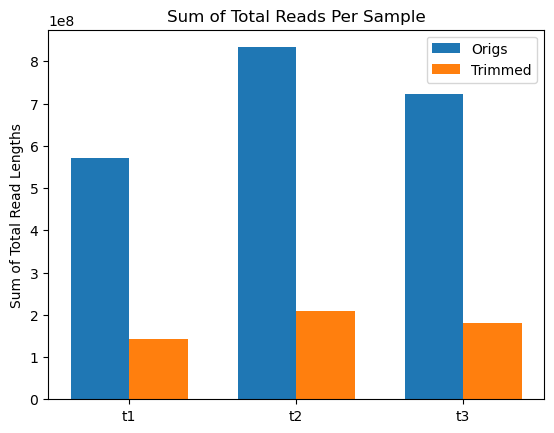

In [45]:
make_table(ins, outs, "Origs", "Trimmed", "Sum of Total Read Lengths", samples, "Sum of Total Reads Per Sample")

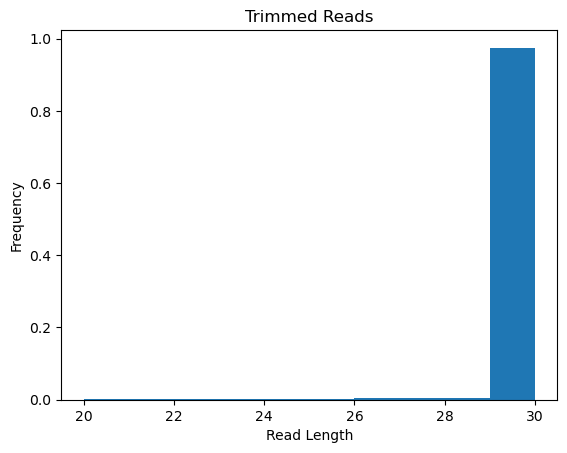

In [46]:
reads = !xargs zcat {out_path}/*.gz | seqtk seq -A  |grep -v ">" 
ds = [len(read) for read in reads]
make_histogram(ds, "Read Length", "Trimmed Reads")

## Step: fastqc_post

#### Post Trimming Quality Control

In [47]:
in_path = mkpath("trim")
out_path = mkpath("fastqc_post")

In [48]:
for sample in samples:
    ! fastqc {fname(in_path,sample,"fq.gz")} -o {out_path} 2> /dev/null

application/gzip
Analysis complete for t1.fq.gz
application/gzip
Analysis complete for t2.fq.gz
application/gzip
Analysis complete for t3.fq.gz


#### Consolidate fastqc Reports

In [49]:
!multiqc -f -fp -m fastqc -n multiqc -o {out_path} {out_path}


  /// ]8;id=673316;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.19

|           multiqc | Only using modules: fastqc
|           multiqc | Search path : /home/cdaniels/uofc_data/ubs_seq/UBS-seq_basic/workspace/fastqc_post
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 6/6  0/6  
|            fastqc | Found 3 reports
|           multiqc | Report      : fastqc_post/multiqc.html
|           multiqc | Data        : fastqc_post/multiqc_data
|           multiqc | MultiQC complete


In [50]:
! ls {out_path}

multiqc_data  t1_fastqc.html  t2_fastqc.html  t3_fastqc.html
multiqc.html  t1_fastqc.zip   t2_fastqc.zip   t3_fastqc.zip


## Step: Hisat3n_align

#### Align Samples to Genome with Hisat-3n

In [51]:
in_path = mkpath("trim")
out_path = mkpath("hisat3n_align")

#### hisat-3n

http://daehwankimlab.github.io/hisat2/hisat-3n/

In [52]:
! hisat-3n --help

HISAT2 version 2.2.1-3n-0.0.3 by Daehwan Kim (infphilo@gmail.com, www.ccb.jhu.edu/people/infphilo)
Usage: 
  hisat2 [options]* -x <ht2-idx> {-1 <m1> -2 <m2> | -U <r>} [-S <sam>]

  <ht2-idx>  Index filename prefix (minus trailing .X.ht2).
  <m1>       Files with #1 mates, paired with files in <m2>.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <m2>       Files with #2 mates, paired with files in <m1>.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <r>        Files with unpaired reads.
             Could be gzip'ed (extension: .gz) or bzip2'ed (extension: .bz2).
  <sam>      File for SAM output (default: stdout)

  <m1>, <m2>, <r> can be comma-separated lists (no whitespace) and can be
  specified many times.  E.g. '-U file1.fq,file2.fq -U file3.fq'.

Options (defaults in parentheses):

 Input:
  -q                 query input files are FASTQ .fq/.fastq (default)
  --qseq             query input files are in Illumina's q

```
hisat3n --index {params.index}
        -p {threads}
        --summary-file {output.summary}
        --new-summary
        -q
        -U {input}
        --directional-mapping
        --base-change C,T
        --pen-noncansplice 20
        --mp 4,1
        --un {output.fq}
        -S {output.sam}
```

##### paramaters:
- --index {params.index}, Index filename prefix (minus trailing .X.ht2) 
- -p {nc}, number of threads
- --summary-file, print alignment summary to this file.
- --new-summary, print alignment summary in a new style, which is more machine-friendly.
- -q, query input files are FASTQ .fq/.fastq (default)
- -U {input}, 
- --directional-mapping, make directional mapping, please use this option only if your reads are prepared with a strand specific library (off)
- --base-change C,T,  the converted nucleotide and converted to nucleotide (C,T)
- --pen-noncansplice 20, penalty for a non-canonical splice site (12)
- --mp 4,1,  max and min penalties for mismatch; lower qual = lower penalty <6,2>
- --un {output.fq}, write unpaired reads that didn't align to <path> 
- -S {output.sam}, File for SAM output (default: stdout)

In [53]:
for sample in samples:
    !hisat-3n --index {genome_idx}\
        -p {nc}\
        --summary-file {fname(out_path,sample,"summary")}\
        --new-summary\
        -q\
        -U {fname(in_path,sample,'fq.gz')}\
        --directional-mapping\
        --base-change C,T\
        --pen-noncansplice 20\
        --mp 4,1\
        --un {fname(out_path,sample,'unmapped.fq')}\
        -S {fname(out_path,sample,'sam')}

HISAT2 summary stats:
	Total reads: 4652729
		Aligned 0 time: 813137 (17.48%)
		Aligned 1 time: 2714806 (58.35%)
		Aligned >1 times: 1124786 (24.17%)
	Overall alignment rate: 82.52%
HISAT2 summary stats:
	Total reads: 6780142
		Aligned 0 time: 1247996 (18.41%)
		Aligned 1 time: 3917003 (57.77%)
		Aligned >1 times: 1615143 (23.82%)
	Overall alignment rate: 81.59%
HISAT2 summary stats:
	Total reads: 5876778
		Aligned 0 time: 1077999 (18.34%)
		Aligned 1 time: 3405853 (57.95%)
		Aligned >1 times: 1392926 (23.70%)
	Overall alignment rate: 81.66%


#### Analysis

In [54]:
!ls -lh {out_path}

total 6.9G
-rw-rw-r-- 1 cdaniels cdaniels 1.8G Feb  3 04:23 t1.sam
-rw-rw-r-- 1 cdaniels cdaniels  182 Feb  3 04:23 t1.summary
-rw-rw-r-- 1 cdaniels cdaniels  91M Feb  3 04:23 t1.unmapped.fq
-rw-rw-r-- 1 cdaniels cdaniels 2.6G Feb  3 04:25 t2.sam
-rw-rw-r-- 1 cdaniels cdaniels  183 Feb  3 04:25 t2.summary
-rw-rw-r-- 1 cdaniels cdaniels 139M Feb  3 04:25 t2.unmapped.fq
-rw-rw-r-- 1 cdaniels cdaniels 2.3G Feb  3 04:26 t3.sam
-rw-rw-r-- 1 cdaniels cdaniels  183 Feb  3 04:26 t3.summary
-rw-rw-r-- 1 cdaniels cdaniels 120M Feb  3 04:26 t3.unmapped.fq


In [55]:
! cat {out_path}/t1.summary

HISAT2 summary stats:
	Total reads: 4652729
		Aligned 0 time: 813137 (17.48%)
		Aligned 1 time: 2714806 (58.35%)
		Aligned >1 times: 1124786 (24.17%)
	Overall alignment rate: 82.52%


In [56]:
! head -8 {out_path}/t1.unmapped.fq

@SRR23538290.540_TTCAACACTC 540 length=121
GTAATGAAGGGTAAGATGAAGTGAAAGGTA
+
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFF
@SRR23538290.203_GGCTAGGGGG 203 length=121
TGTTGAAAATGAGATTAAGATAGTGTA
+
FFFFFFFF,:FFFFFFFFFFFFFF,FF


In [57]:
! grep -v '@' {out_path}/t1.sam |head -1

SRR23538290.540_TTCAACACTC	4	*	0	0	*	*	0	0	GTAATGAAGGGTAAGATGAAGTGAAAGGTA	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFF	YT:Z:UU
grep: write error: Broken pipe


## Step: Hisat3n_sort

#### Sort and Index Hisat3n Sam Files

In [58]:
in_path = mkpath("hisat3n_align")
out_path = mkpath("hisat3n_sort")

#### samtools

http://www.htslib.org/doc/samtools.html

```
samtools view
    -@ {threads}
    -F4 -b {input} |
samtools sort
    -@ {threads}
    --write-index
    -m 4G
    -O BAM
    -o {output} -
```

##### paramaters:
```
samtools view, SAM<->BAM<->CRAM conversion
    -@ {nc}, number of threads 
    -F4, have none of the FLAGs present (-F 4 filters out unmapped reads) 
    -b, output a bam file
    {input}  |
samtools sort, sort alignment file
    -@ {nc}, number of threads
    --write-index, index the output files
    -O BAM, output file format
    -o {output} -
```

In [59]:
for sample in samples:
    ! samtools view -@ {nc} -F4 -b {fname(in_path, sample,'sam')}  | \
      samtools sort -@ {nc} --write-index -O BAM -o {fname(out_path,sample,'bam')} - 

[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...
[bam_sort_core] merging from 0 files and 32 in-memory blocks...


#### Analysis

In [60]:
! ls -lh {out_path}

total 784M
-rw-rw-r-- 1 cdaniels cdaniels 215M Feb  3 04:26 t1.bam
-rw-rw-r-- 1 cdaniels cdaniels 975K Feb  3 04:26 t1.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels 301M Feb  3 04:26 t2.bam
-rw-rw-r-- 1 cdaniels cdaniels 897K Feb  3 04:26 t2.bam.csi
-rw-rw-r-- 1 cdaniels cdaniels 265M Feb  3 04:27 t3.bam
-rw-rw-r-- 1 cdaniels cdaniels 927K Feb  3 04:27 t3.bam.csi


## Step: Hisat3n_dedup

#### Remove Dulpicate Reads

In [61]:
in_path = mkpath("hisat3n_sort")
out_path = mkpath("hisat3n_dedup")

#### umicollapse

https://github.com/Daniel-Liu-c0deb0t/UMICollapse

##### paramaters:
```
umicollapse bam, use a bam file
    --two-pass, use a separate two-pass algorithm for SAM/BAM deduplication.
    -i {input.bam}, indexed input bam file
    -o {output.bam}, output bam file
      > {output.log}
```

In [62]:
for sample in samples:
    !umicollapse bam  \
    -i {fname(in_path,sample,'bam')} \
    -o {fname(out_path,sample,'bam')}\
    >  {fname(out_path,sample,'log')}

Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-02-03 04:27:24	SortingCollection	Creating merging iterator from 16 files
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-02-03 04:33:11	SortingCollection	Creating merging iterator from 23 files
Picked up _JAVA_OPTIONS: -Xmx8g
INFO	2024-02-03 04:39:56	SortingCollection	Creating merging iterator from 20 files


#### Analysis

In [63]:
! ls -lh {out_path}

total 794M
-rw-rw-r-- 1 cdaniels cdaniels 219M Feb  3 04:27 t1.bam
-rw-rw-r-- 1 cdaniels cdaniels  452 Feb  3 04:27 t1.log
-rw-rw-r-- 1 cdaniels cdaniels 306M Feb  3 04:39 t2.bam
-rw-rw-r-- 1 cdaniels cdaniels  455 Feb  3 04:39 t2.log
-rw-rw-r-- 1 cdaniels cdaniels 270M Feb  3 04:40 t3.bam
-rw-rw-r-- 1 cdaniels cdaniels  450 Feb  3 04:40 t3.log


In [64]:
! cat {out_path}/t1.log

Arguments	[bam, -i, hisat3n_sort/t1.bam, -o, hisat3n_dedup/t1.bam]
Done reading input file into memory!
Number of input reads	8319859
Number of removed unmapped reads	0
Number of unremoved reads	8319859
Number of unique alignment positions	4385853
Average number of UMIs per alignment position	1.8292589833722197
Max number of UMIs over all alignment positions	357
Number of reads after deduplicating	7946319
UMI collapsing finished in 40.323 seconds!


## Step: Hisat3n_call

#### Call Converted bases

In [74]:
in_path = mkpath("hisat3n_dedup")
out_path = mkpath("hisat3n_call")

#### hisat-3n-table

http://daehwankimlab.github.io/hisat2/hisat-3n/

##### paramaters:
```
samtools view -e "rlen<100000" -h {input} |
hisat3ntable
    -p {threads}
    -m --alignments -
    --ref {params.fa}
    --output-name /dev/stdout
    --base-change C,T                      |
    bgzip -@ {threads} -c > {output}
```

In [66]:
for sample in samples:
    !samtools view -e "rlen<100000" -h {fname(in_path,sample,'bam')} |\
    hisat-3n-table\
        -p {nc}\
        -m --alignments -\
        --ref {genome_fa}\
        --output-name /dev/stdout\
        --base-change C,T                          |\
    bgzip \
        -@ {nc} \
        -c > {fname(out_path,sample,'tsv.gz')}

#### Analysis

In [75]:
! ls -lh {out_path}

total 91M
-rw-rw-r-- 1 cdaniels cdaniels 54K Feb  3 05:05 t1_filtered.csv
-rw-rw-r-- 1 cdaniels cdaniels 26M Feb  3 04:48 t1.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 35M Feb  3 04:56 t2.tsv.gz
-rw-rw-r-- 1 cdaniels cdaniels 31M Feb  3 05:05 t3.tsv.gz


There are 7 columns in the 3N-conversion-table:

1. `ref:` the chromosome name.
2. `pos:` 1-based position in ref.
3. `strand:` ‘+’ for forward strand. ‘-‘ for reverse strand.
4. `convertedBaseQualities:` the qualities for converted base in read-level measurement. Length of this string is equal to the number of converted Base in read-level measurement.
5. `convertedBaseCount:` number of distinct read positions where converted base in read-level measurements were found. this number should equal to the length of convertedBaseQualities.
6. `unconvertedBaseQualities:` the qualities for unconverted base in read-level measurement. Length of this string is equal to the number of unconverted Base in read-level measurement.
7. `unconvertedBaseCount:` number of distinct read positions where unconverted base in read-level measurements were found. this number should equal to the length of unconvertedBaseQualities.

In [68]:
! zcat {out_path}/t1.tsv.gz |head -20

ref	pos	strand	convertedBaseQualities	convertedBaseCount	unconvertedBaseQualities	unconvertedBaseCount
1	10567	-	F	1		0
1	10572	-	F	1		0
1	10578	-	F	1		0
1	10580	-	F	1		0
1	10581	-	F	1		0
1	10583	-	F	1		0
1	10590	-	F	1		0
1	10591	-	F	1		0
1	10592	-	F	1		0
1	10596	-	F	1		0
1	11491	+	F	1		0
1	11500	+	F	1		0
1	11502	+	:	1		0
1	11509	+		0	F	1
1	11511	+		0	F	1
1	12558	+	F	1		0
1	12563	+	F	1		0
1	12566	+	F	1		0
1	12581	+	F	1		0

gzip: stdout: Broken pipe


In [101]:
df = pd.read_csv(out_path/'t1.tsv.gz', sep='\t', compression='gzip', low_memory=False, dtype={4: int, 6: int })

In [133]:
p1 = len(df[df.unconvertedBaseCount == 1])/len(df);
p1

0.017151172450944555

In [136]:
p2 = len(df[df.unconvertedBaseCount == 2])/len(df);
p2

0.002095434317852818

In [137]:
p3 = len(df[df.unconvertedBaseCount == 3])/len(df);
p3

0.0007013542608583107

In [132]:
p1*p1

0.0002941627164420395

In [111]:
df2 = df[(df['unconvertedBaseCount'] > 1) &  (df['unconvertedBaseCount'] > df['convertedBaseCount'])]

In [118]:
df2.to_csv(out_path/'t1_filtered.csv',index=False)  # Set index=False if you don't want to save row indices

In [113]:
df2.iloc[0:9,]

,ref,pos,strand,convertedBaseQualities,convertedBaseCount,unconvertedBaseQualities,unconvertedBaseCount
6386,1,629231,+,NaN,0,FF,2
6388,1,629236,+,NaN,0,FFF,3
6389,1,629238,+,NaN,0,FFF,3
6390,1,629241,+,F,1,F:FFF,5
6391,1,629243,+,F,1,FFFFF,5
6392,1,629246,+,F,1,FFFFF,5
6394,1,629256,+,F,1,:FFF,4
6395,1,629258,+,F,1,FFFF,4
6396,1,629259,+,F,1,",FFF",4


In [88]:
end = ! echo 'ubs_basic.ipnby | ubs_basic.py ENDED  :' `date`
end = end[0]

In [89]:
print(start)
print(end)

ubs_basic.ipnby | ubs_basic.py STARTED: Sat Feb 3 05:58:39 AM CST 2024
ubs_basic.ipnby | ubs_basic.py ENDED  : Sat Feb 3 06:00:40 AM CST 2024
